In [3]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2 #must install using "conda install -c conda-forge opencv" into the terminal
print(cv2.__version__)
import pickle

4.10.0


In [4]:
car_paths = glob("../input/the-car-connection-picture-dataset"+"/*")[:5000] #must download https://www.kaggle.com/datasets/prondeau/the-car-connection-picture-dataset?resource=download
neg_paths = []

for class_path in glob("../input/natural-images/natural_images"+"/*"):
    if class_path != "../input/natural-images/natural_images/car":   #must dowload https://www.kaggle.com/datasets/prasunroy/natural-imagesv 
        paths = random.choices(glob(class_path+"/*"),k=700)
        neg_paths = paths + neg_paths
        
print("There are {} car images in the dataset".format(len(car_paths)))
print("There are {} negative images in the dataset".format(len(neg_paths)))

There are 5000 car images in the dataset
There are 5600 negative images in the dataset


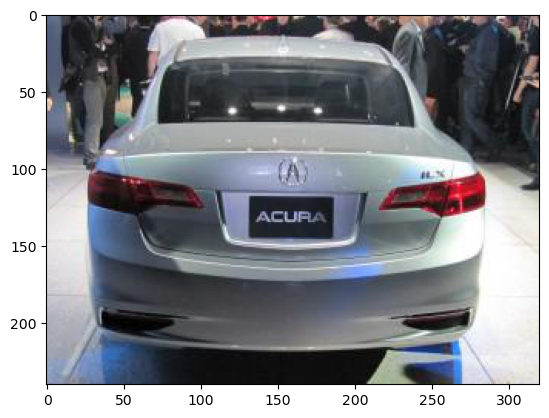

In [11]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image)

for file in car_paths[:1]:
    process(file)

In [4]:
for file in neg_paths[1020:1022]:
    process(file)

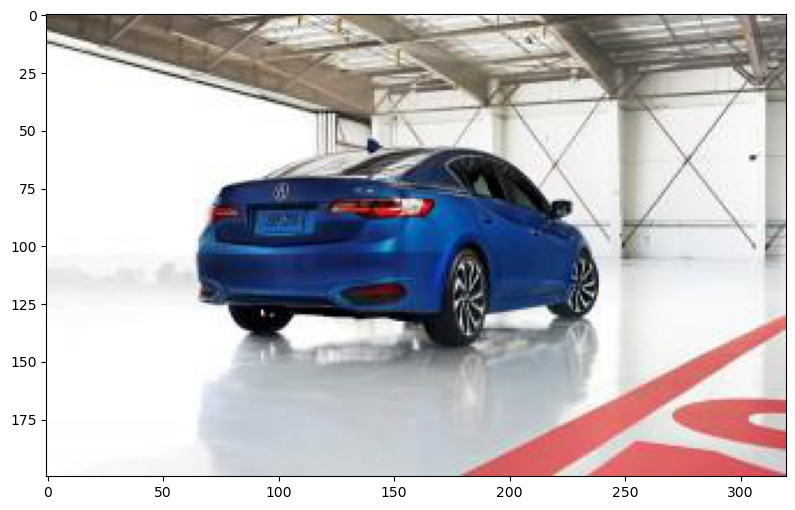

In [12]:
example_image = np.asarray(PIL.Image.open(car_paths[51]))
fig = plt.figure(figsize=(12,6))
plt.imshow(example_image)

In [13]:
example_image.shape

(200, 320, 3)

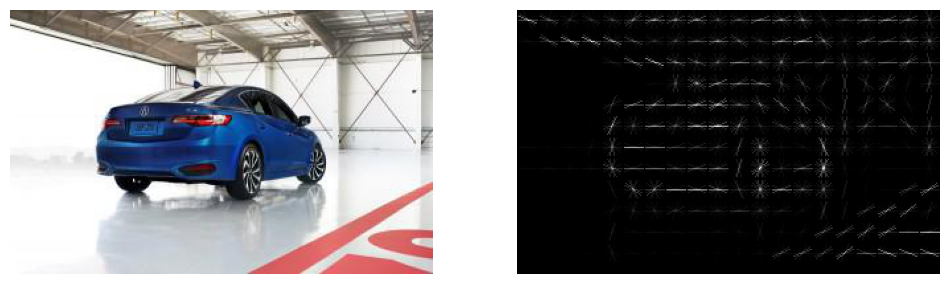

In [16]:
from skimage.feature import hog

hog_features, visualized = hog(image=example_image,
                              orientations=9,
                              pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True,
                              channel_axis=-1)

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [17]:
hog_features.shape

(7524,)

In [18]:
pos_images = []
neg_images = []

pos_labels = np.ones(len(car_paths))
neg_labels = np.zeros(len(neg_paths))

start = time.time()

for car_path in car_paths:    
    img = np.asarray(PIL.Image.open(car_path))
    # We don't have to use RGB channels to extract features, Grayscale is enough.
    img = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
    pos_images.append(img)

for neg_path in neg_paths:
    img = np.asarray(PIL.Image.open(neg_path))
    img = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )
    
    neg_images.append(img)
    
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))
    
processTime = round(time.time()-start,2)
print("Reading images and extracting features has taken {} seconds".format(processTime))

print("Shape of image set",x.shape)
print("Shape of labels",y.shape)

Reading images and extracting features has taken 17.44 seconds
Shape of image set (10600, 540)
Shape of labels (10600,)


In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8480, 540)
(2120, 540)
(8480,)
(2120,)


In [20]:
from sklearn.svm import SVC

# Creating a SVC object
svc = SVC(kernel = 'rbf', verbose=True, random_state=42)

# Fit the training dataset
svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

[LibSVM]Accuracy score of model is  96.51


In [21]:
# testing
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2), visualize=True)
        
    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])
    
    print("True label: ", true_label)
    plt.imshow(img)
    if pred[0] == 0.0:
        print("Prediction: Not car")
        
    elif pred[0] == 1.0:
        print("Prediction: Car")

True label:  Not car
Prediction: Not car


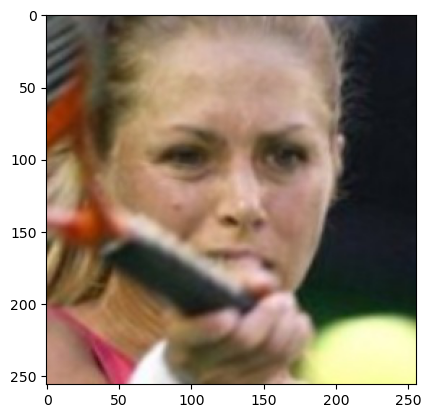

In [22]:
test_prediction(neg_paths[2], "Not car", svc)

True label:  Car
Prediction: Car


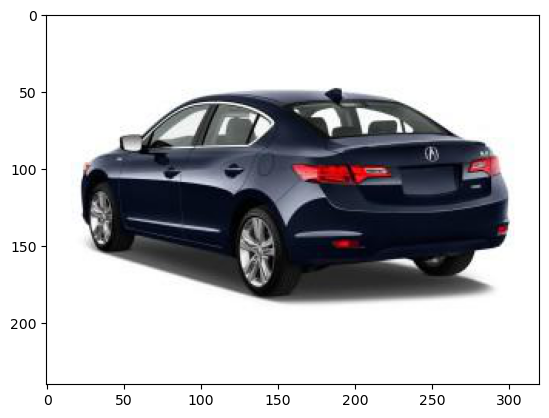

In [23]:
test_prediction(car_paths[15], "Car", svc)

True label:  Car
Prediction: Car


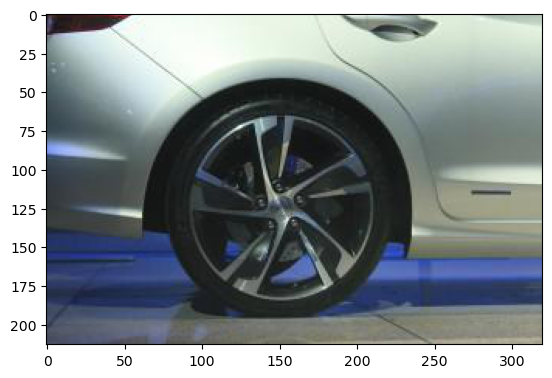

In [24]:
test_prediction(car_paths[3], "Car", svc)

True label:  Not car
Prediction: Not car


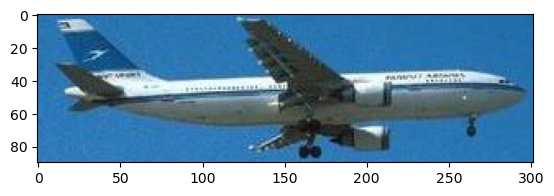

In [25]:
test_prediction(neg_paths[-1], "Not car", svc)

In [26]:
# Creating a SVC object
svc = SVC()
svc1 = SVC(C=0.01)
svc2 = SVC(C=100)

# Fitting the parameters
svc.fit(x_train,y_train)
svc1.fit(x_train,y_train)
svc2.fit(x_train,y_train)


y_pred = svc.predict(x_test)
print("Accuracy score of svc model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc1.predict(x_test)
print("Accuracy score of svc1 model with c=0.01 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc2.predict(x_test)
print("Accuracy score of svc2 model with c=100 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

Accuracy score of svc model is  96.51
Accuracy score of svc1 model with c=0.01 is  88.58
Accuracy score of svc2 model with c=100 is  97.03


True label:  Not car
Prediction: Not car


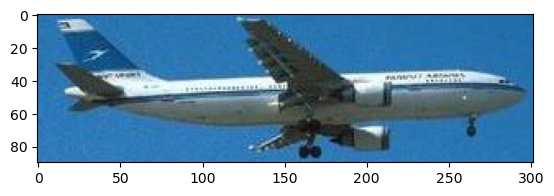

In [27]:
test_prediction(neg_paths[-1], "Not car", svc2)

True label:  Not car
Prediction: Not car


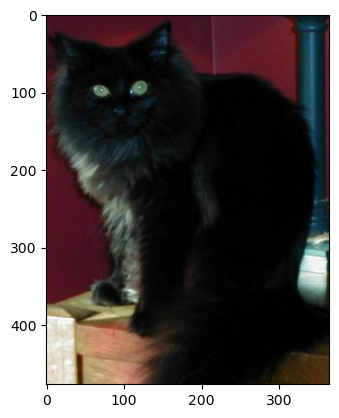

In [28]:
test_prediction(neg_paths[4000], "Not car", svc2)

In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc, x_test, y_test, cv=5)
scores1 = cross_val_score(svc1, x_test, y_test, cv=5)
scores2 = cross_val_score(svc2, x_test, y_test, cv=5)
print("Accuracy for svc with c=1.0: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Accuracy for svc with c=0.01: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
print("Accuracy for svc with c=100: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

Accuracy for svc with c=1.0: 0.94 (+/- 0.03)
Accuracy for svc with c=0.01: 0.82 (+/- 0.03)
Accuracy for svc with c=100: 0.94 (+/- 0.02)


In [30]:
def slideExtract(image,windowSize=(96,64),channel="RGB",step=12):
    
    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            features_of_window = hog(window,orientations=9,pixels_per_cell=(16,16),
                                     cells_per_block=(2,2)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [31]:
example_image = np.asarray(PIL.Image.open("../input/the-car-connection-picture-dataset/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Mro.jpg"))
coords,features = slideExtract(example_image,channel="RGB")

coords[:5]

[(0, 96, 0, 64),
 (0, 96, 12, 76),
 (0, 96, 24, 88),
 (0, 96, 36, 100),
 (0, 96, 48, 112)]

In [33]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

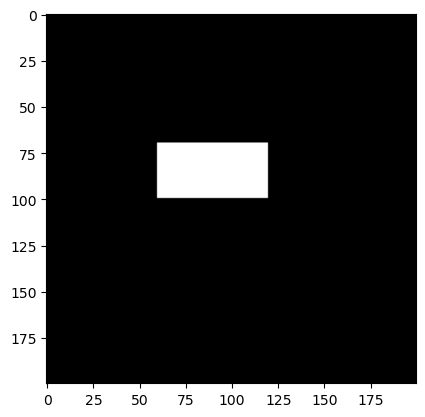

In [34]:
example_mask = np.zeros((200,200))
example_mask[70:100,60:120] = 255

plt.imshow(example_mask,cmap="gray")
plt.show()

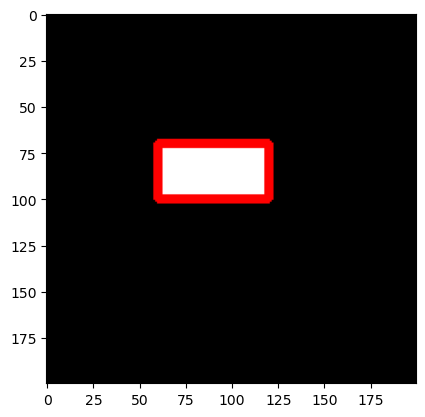

In [35]:
# Find contours function of openCV will help us the find white regions.
contours, hierarchy = cv2.findContours(example_mask.astype(np.uint8),1,2)[-2:]
for c in contours:
    if cv2.contourArea(c) < 10*10:
        continue
    (x,y,w,h) = cv2.boundingRect(c)
    
    rgb_ver = cv2.cvtColor(example_mask.astype(np.uint8),cv2.COLOR_GRAY2RGB)
    im = cv2.rectangle(rgb_ver,(x,y),(x+w,y+h),(255,0,0),3)

plt.imshow(im)

In [36]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = svc.predict([features[i]])
        if decision[0] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

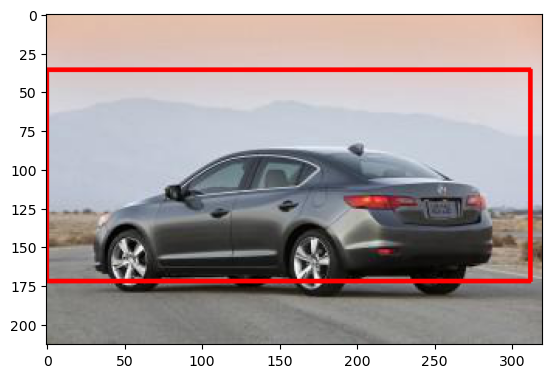

In [40]:
detected = detect(np.array(PIL.Image.open("../input/the-car-connection-picture-dataset/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_ylA.jpg")).copy())
plt.imshow(detected)

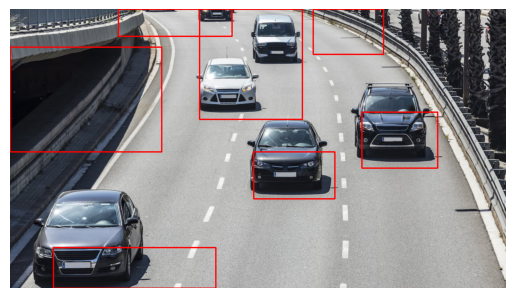

In [42]:
import io
import requests

byte_img = requests.get("https://images2.minutemediacdn.com/image/upload/c_crop,h_843,w_1500,x_0,y_69/f_auto,q_auto,w_1100/v1554995310/shape/mentalfloss/istock-472964014.jpg").content
byte_img = io.BytesIO(byte_img)

img = np.array(PIL.Image.open(byte_img)).copy()


detected = detect(img)
plt.imshow(detected)
plt.axis("off")
plt.show()